# Set Up

## Loading Libraries

In [1]:
# linear algebra
import numpy as np 
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 

# data check
from collections import Counter

# transformer
import torch
from transformers import BertModel, BertTokenizer
import datasets

# analysis
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# use biopython to extract protein properties
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# util
from tqdm import tqdm

# Input data files are available in the read-only "/input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Load Model

### ProtBert model is being loaded from Rosatlab which is a pretrained model on protien sequence. This model can be used for feature extraction as well as for fine tuning.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert").to(device)

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Data Preparation

## Load Data

In [9]:
train = pd.read_csv('input/novozymes-enzyme-stability-prediction/train.csv')
train_update = pd.read_csv('input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv',
                           index_col='seq_id')
#Dropping "data_source" column as it has no data
train_update = train_update.drop('data_source', axis = 1)
test = pd.read_csv('input/novozymes-enzyme-stability-prediction/test.csv')

## Data Correction

In [10]:
train_drop_id = train_update[train_update.isnull().all('columns')].index
train_swap_id = train_update[train_update.notnull().all('columns')].index

train = train.drop(train.index[train_drop_id], axis = 0)
train.loc[train_swap_id, ['pH','tm']] = train_update.loc[train_swap_id, ['pH','tm']]
train = train.reset_index(drop = True)

## Checking Input Sequence Length

In [15]:
train['seq_length'] = [len(s) for s in train['protein_sequence']]
print(f"MIN :{train['seq_length'].min()}\nMAX :{train['seq_length'].max()}\n\
MEAN :{train['seq_length'].mean()}\nMEDIAN :{train['seq_length'].median()}")

MIN :5
MAX :8798
MEAN :450.468617370001
MEDIAN :351.0


## Drop too long sequences

In [16]:
train['seq_length'].quantile(0.90)

851.0

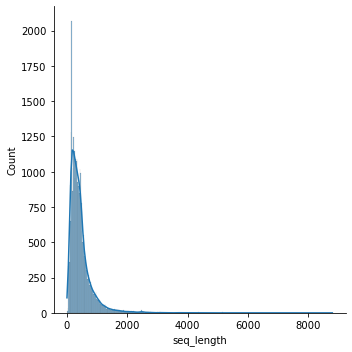

In [20]:
sns.displot(train['seq_length'],kde=True)

In [21]:
# drop too long sequence
train_long_id = train[train['seq_length']>851].index
train = train.drop(train.index[train_long_id], axis = 0)
train = train.reset_index(drop = True)

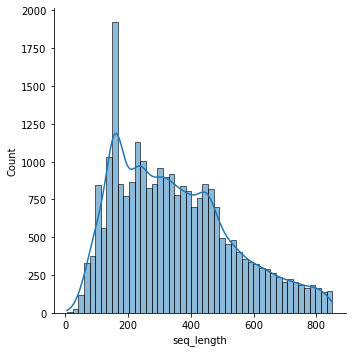

In [22]:
sns.displot(train['seq_length'],kde=True)

#### We are dropping sequences that are too long to save the GPU memory, as from the above plots you can observe that most of the sequence has length between 200 and 850.

# Test Prot_Bert

## Tokenize sequences

### Test by single sequence

In [26]:
sequence_example = train['protein_sequence'][4]
sequence_example = ' '.join(list(sequence_example))
encoded_input = tokenizer(sequence_example, return_tensors='pt').to(device)
output = model(**encoded_input)

In [27]:
encoded_input['input_ids'].shape

torch.Size([1, 382])

In [28]:
output['last_hidden_state'].shape

torch.Size([1, 382, 1024])

In [29]:
output['last_hidden_state'][:,0][0].detach().cpu().numpy()

array([ 0.05609831,  0.01732929,  0.03116154, ...,  0.03675359,
       -0.00251826, -0.03068385], dtype=float32)

In [30]:
len(output['last_hidden_state'][:,0][0].detach().cpu().numpy())

1024

#### The tokenizer of prot_bert only accept white space splitted sequence. So added spaces before processing the sequence.